In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezasouri","key":"d7be552bcbe38f8b427915cbd756cc73"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ssarkar445/covid-19-xray-and-ct-scan-image-dataset

 99% 3.71G/3.74G [00:28<00:00, 184MB/s]
100% 3.74G/3.74G [00:28<00:00, 141MB/s]


In [ ]:
! unzip covid-19-xray-and-ct-scan-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19 Dataset/X-ray/Non-COVID/01.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/010.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0100.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0101.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0102.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0103.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0104.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0105.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0106.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0107.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0108.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0109.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/011.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0110.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0111.jpeg  
  inflating: COVID-19 Dataset/X-ray/Non-COVID/0112.jpeg  
  inflating: COVID-19 Dat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [ ]:
path ='/content/COVID-19 Dataset/CT/COVID'
# x=os.listdir(path)
# print(len(x))
for count, filename in enumerate(os.listdir(path)):
  dst ="covid" + str(count) + ".png"
  src =path+"/" + filename 
  dst =path+"/"+ dst
  os.rename(src,dst)
  # print(src)
path='/content/COVID-19 Dataset/CT/Non-COVID'
for count, filename in enumerate(os.listdir(path)): 
  dst ="noncovid" + str(count) + ".png"
  src =path+"/"+ filename 
  dst =path+ "/"+dst 
  # rename() function will 
  # rename all the files 
  os.rename(src, dst)

In [ ]:
disease_types=['COVID', 'Non-COVID']
data_dir = '/content/COVID-19 Dataset/CT/'
train_dir = os.path.join(data_dir)


In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
  for file in os.listdir(os.path.join(train_dir, sp)):
    train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/covid2765.png,0,COVID
1,COVID/covid2466.png,0,COVID
2,COVID/covid2671.png,0,COVID
3,COVID/covid5220.png,0,COVID
4,COVID/covid5221.png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/covid4614.png,0,COVID
1,Non-COVID/noncovid571.png,1,Non-COVID
2,COVID/covid4990.png,0,COVID
3,Non-COVID/noncovid2538.png,1,Non-COVID
4,COVID/covid594.png,0,COVID


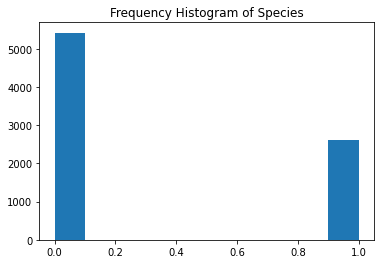

<Figure size 864x864 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

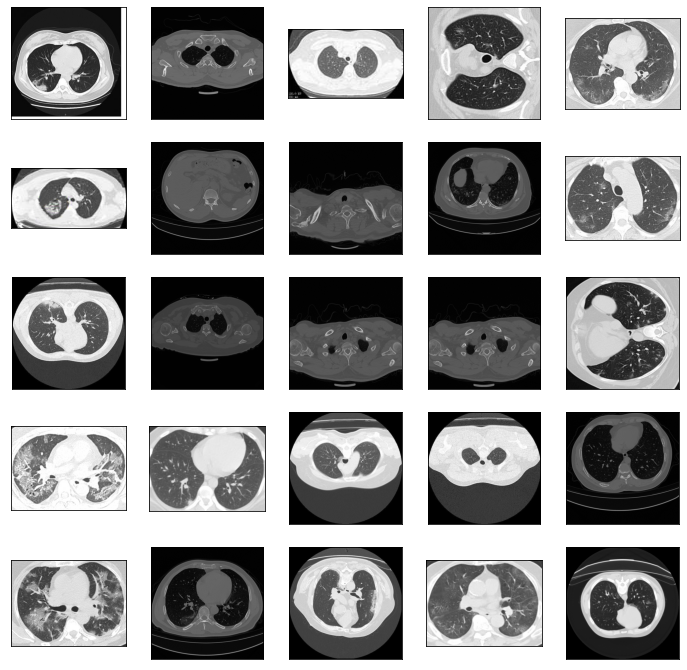

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

8055it [00:38, 209.12it/s]


Train Shape: (8055, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
# Create and Compile the Model
from keras import layers
from keras import models
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout,Input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:

densenet = DenseNet121(
    weights='imagenet',
    include_top=False,

)

model = models.Sequential()
model.add(layers.Input(shape=(64, 64, 3)))
model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(64, 64, 3),padding='same'))
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                         

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               
               validation_data=(X_val, Y_val))

Epoch 1/50
100/100 - 51s - loss: 0.5005 - acc: 0.7837 - val_loss: 0.6240 - val_acc: 0.6865 - 51s/epoch - 508ms/step
Epoch 2/50
100/100 - 13s - loss: 0.3230 - acc: 0.8599 - val_loss: 0.7342 - val_acc: 0.6629 - 13s/epoch - 126ms/step
Epoch 3/50
100/100 - 13s - loss: 0.2819 - acc: 0.8803 - val_loss: 0.5760 - val_acc: 0.7405 - 13s/epoch - 125ms/step
Epoch 4/50
100/100 - 13s - loss: 0.2616 - acc: 0.8906 - val_loss: 0.4642 - val_acc: 0.7722 - 13s/epoch - 125ms/step
Epoch 5/50
100/100 - 12s - loss: 0.2478 - acc: 0.8989 - val_loss: 0.2763 - val_acc: 0.8591 - 12s/epoch - 125ms/step
Epoch 6/50
100/100 - 13s - loss: 0.2299 - acc: 0.9022 - val_loss: 0.3304 - val_acc: 0.8616 - 13s/epoch - 131ms/step
Epoch 7/50
100/100 - 13s - loss: 0.2155 - acc: 0.9111 - val_loss: 0.2701 - val_acc: 0.8814 - 13s/epoch - 131ms/step
Epoch 8/50
100/100 - 13s - loss: 0.2112 - acc: 0.9130 - val_loss: 0.3550 - val_acc: 0.8715 - 13s/epoch - 131ms/step
Epoch 9/50
100/100 - 13s - loss: 0.2030 - acc: 0.9196 - val_loss: 0.2069

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(64, 64), 
#                                                     batch_size=20,
#                                                     class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(validation_dir,
#                                                         target_size=(64, 64),
#                                                         batch_size=20,
#                                                         class_mode='binary')

In [ ]:
# # Fit the model 
# history = model.fit_generator(train_generator,
#                               steps_per_epoch=100,
#                               epochs=50,
#                               validation_data=validation_generator,
#                               validation_steps=10)

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

51/51 [==============================] - 1s 24ms/step - loss: 0.2361 - acc: 0.9199
Final Loss: 0.23606085777282715, Final Accuracy: 0.9199255108833313


51/51 [==============================] - 3s 17ms/step


Text(0.5, 145.31999999999996, 'Predicted')

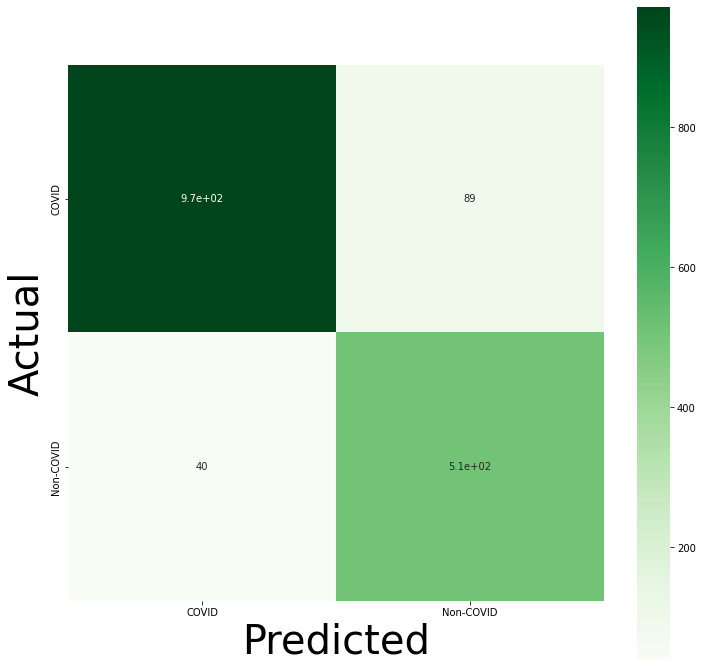

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('F1 Score: %.3f' % f1_score(Y_true, Y_pred ,average='micro'))
print('Precision: %.3f' % precision_score(Y_true, Y_pred ,average='micro'))
print('Accuracy: %.3f' % accuracy_score(Y_true, Y_pred))

F1 Score: 0.920
Precision: 0.920
Accuracy: 0.920


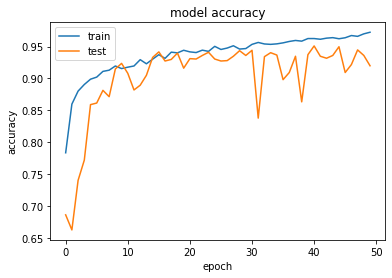

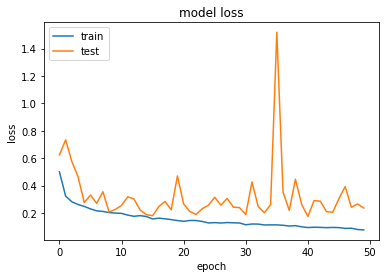

In [ ]:
# accuracy plot 
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()